# 第三课：图神经网络

图神经网络（Graph Neural Network, GNN）是深度神经网络（Deep Neural Network, DNN）在图数据上的泛化，它是非常强力的图特征提取工具。在本次实践课中，我们将讲解常见的图神经网络比如GCN和GAT，以及如何利用图神经网络来完成节点分类和图分类问题。

## 1. GCN

### 1.1 用矩阵形式实现GCN

首先我们来回顾一下GCN每一层的操作。给定图的邻接矩阵$A$和节点特征矩阵$X$，如果我们用$W$表示GCN层中的参数、$H$表示隐藏层的特征，那么一层GCN中的操作可以表达为$H=\text{ReLU}(AXW)$。

In [1]:
# 导入需要用到的工具包
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import torch.optim as optim
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score
import scipy.sparse as sp
import numpy as np

In [2]:
class GraphConvolution(nn.Module):
    """GCN层，参考https://github.com/tkipf/pygcn
    
    参数说明
    ----------
    in_features : 输入特征的维度
    out_features : 输出神经元的数量，也即类别的数量
    with_bias: 是否带有偏置项
    """

    def __init__(self, in_features, out_features, with_bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if with_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self): 
        """初始化参数"""
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
        """前向传播"""
        if x.data.is_sparse:
            support = torch.spmm(x, self.weight) # XW
        else:
            support = torch.mm(x, self.weight) # XW
        output = torch.spmm(adj, support) # AXW
        if self.bias is not None:
            return output + self.bias # AXW + b
        else:
            return output # AXW

In [3]:
class GCN(nn.Module):
    """ 2层GCN
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):

        super(GCN, self).__init__()

        self.nfeat = nfeat
        self.hidden_sizes = [nhid]
        self.nclass = nclass
        self.gc1 = GraphConvolution(nfeat, nhid, with_bias=with_bias)
        self.gc2 = GraphConvolution(nhid, nclass, with_bias=with_bias)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

    def initialize(self):
        """初始化每一层的参数"""
        self.gc1.reset_parameters()
        self.gc2.reset_parameters()

定义好GCN模型后，我们来简单看看怎么使用这个模型。我们继续以Cora数据集为例。

In [4]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.utils import to_scipy_sparse_matrix
# dataset = Planetoid(root='./data', name='Cora') # 将数据保存在data文件夹下
# data = dataset[0]
# adj = to_scipy_sparse_matrix(data.edge_index)
# features = data.x
# labels = data.y

from dgl.data import CoraGraphDataset

dataset = CoraGraphDataset('./data') # 将数据保存在data文件夹下
g = dataset[0]
adj = g.adj(scipy_fmt='coo')

features = g.ndata['feat']
labels = g.ndata['label']

Using backend: pytorch


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [5]:
adj

<2708x2708 sparse matrix of type '<class 'numpy.int64'>'
	with 10556 stored elements in COOrdinate format>

In [6]:
features

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])

接下来我们对邻接矩阵adj进行标准化（normalize）： 

$A \leftarrow A + I$

$\hat{A}= D^{-1/2}{A}D^{-1/2}$ 

In [7]:
def normalize_adj(mx):
    """标准化：A' = (D + I)^-1/2 * ( A + I ) * (D + I)^-1/2
    """
    mx = mx + sp.eye(mx.shape[0])
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1/2).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    mx = mx.dot(r_mat_inv)
    return mx

In [8]:
adj_norm = normalize_adj(adj)
adj_norm

<2708x2708 sparse matrix of type '<class 'numpy.float64'>'
	with 13264 stored elements in Compressed Sparse Row format>

In [9]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """将scipy.sparse形式的稀疏矩阵变成torch里的sparse tensor"""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    sparserow=torch.LongTensor(sparse_mx.row).unsqueeze(1)
    sparsecol=torch.LongTensor(sparse_mx.col).unsqueeze(1)
    sparseconcat=torch.cat((sparserow, sparsecol),1)
    sparsedata=torch.FloatTensor(sparse_mx.data)
    return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))

In [10]:
adj_norm = sparse_mx_to_torch_sparse_tensor(adj_norm)
adj_norm

tensor(indices=tensor([[   0,    1,    2,  ..., 2707, 2706, 2707],
                       [   0,    0,    0,  ..., 2706, 2707, 2707]]),
       values=tensor([0.1667, 0.1826, 0.1826,  ..., 0.5000, 0.5000, 0.5000]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [11]:
nclass = labels.max().item()+1
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
output = model(features, adj_norm)
print(output.shape)
print(output)

torch.Size([2708, 7])
tensor([[-1.7090, -1.9622, -2.3084,  ..., -2.1719, -1.7673, -1.6742],
        [-1.7079, -1.9401, -2.3090,  ..., -2.1890, -1.7691, -1.6775],
        [-1.7079, -1.9407, -2.3082,  ..., -2.1895, -1.7691, -1.6779],
        ...,
        [-1.6835, -1.9160, -2.3251,  ..., -2.2217, -1.7799, -1.6721],
        [-1.7754, -1.9977, -2.2810,  ..., -2.0962, -1.7679, -1.6695],
        [-1.7754, -1.9977, -2.2810,  ..., -2.0962, -1.7679, -1.6695]],
       grad_fn=<LogSoftmaxBackward>)


### 1.2 DGL实现GCN

在这个小节，我们通过DGL来实现GCN。DGL中GCN的实现与上面用矩阵乘法的实现的核心不同是：

*DGL中，对`graph`是核心数据结构，GNN的操作是对`graph`进行，而不是`torch.SparseTensor`。*


#### 1.2.1 直接调用DGL提供的接口

In [12]:
from dgl.nn import GraphConv

class GCN(torch.nn.Module):
    """ 2层GCN
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    dropout : dropout中的概率
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, dropout=0.5, with_bias=True):
        super(GCN, self).__init__()
        """DGL的GraphConv允许传入Activation函数"""
        self.conv1 = GraphConv(nfeat, nhid, bias=with_bias, activation=F.relu)
        self.conv2 = GraphConv(nhid, nclass, bias=with_bias)
        self.dropout = dropout
        
    def reset_parameters(self):
        """初始化模型参数"""
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, g, features):
        """模型前向传播"""
        h = self.conv1(g, features)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.conv2(g, h)
        return F.log_softmax(h, dim=1)

In [13]:
nclass = labels.max().item()+1
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
output = model(g, features)
print(output)
print(output.shape)

tensor([[-1.9511, -1.9457, -1.9431,  ..., -1.9465, -1.9508, -1.9402],
        [-1.9496, -1.9450, -1.9438,  ..., -1.9460, -1.9501, -1.9420],
        [-1.9496, -1.9450, -1.9438,  ..., -1.9460, -1.9501, -1.9420],
        ...,
        [-1.9476, -1.9420, -1.9433,  ..., -1.9512, -1.9502, -1.9412],
        [-1.9428, -1.9403, -1.9379,  ..., -1.9637, -1.9732, -1.9233],
        [-1.9424, -1.9503, -1.9428,  ..., -1.9636, -1.9556, -1.9316]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2708, 7])


#### 1.2.2 详细讲解`GraphConv`内部结构

下面这部分代码来自DGL中的[graphconv.py](https://github.com/dmlc/dgl/blob/master/python/dgl/nn/pytorch/conv/graphconv.py#L141)，这里做了一些修改（删除了一些不重要的变量和更高级选项逻辑的代码）来让它更简洁易懂。

In [14]:
import torch as th
from torch import nn
from torch.nn import init
from dgl import function as fn
from dgl.utils import expand_as_pair


class GraphConv(nn.Module):
    def __init__(self,
                 in_feats,           # 输入的维度
                 out_feats,          # 输出的维度
                 bias=True,          # 是否使用bias
                 activation=None):   # 使用哪种激活函数
        super(GraphConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        # 设定维度变换权重
        self.weight = nn.Parameter(th.Tensor(in_feats, out_feats))
        # 设定bias
        if bias:
            self.bias = nn.Parameter(th.Tensor(out_feats))
        else:
            self.register_parameter('bias', None)
        # 重新初始化参数
        self.reset_parameters()
        # 设定激活函数
        self._activation = activation

    def reset_parameters(self):
        if self.weight is not None:
            init.xavier_uniform_(self.weight)
        if self.bias is not None:
            init.zeros_(self.bias)

    def forward(self, graph, feat):

        with graph.local_scope():
            # GCN的消息传递函数就是复制邻居的特征
            msg_fn = fn.copy_src('h', 'm')
            
            # 对节点的特征按出度进行标准化
            feat_src, feat_dst = expand_as_pair(feat, graph)
            degs = graph.out_degrees().float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_src.dim() - 1)
            norm = th.reshape(norm, shp)
            feat_src = feat_src * norm
            # 先进行维度变换，并送进图里的节点
            feat_src = th.matmul(feat_src, self.weight)
            graph.srcdata['h'] = feat_src
            # DGL最核心的消息传递+聚合更新的函数
            graph.update_all(msg_fn, fn.sum(msg='m', out='h'))
            # 从图里把计算后的特征取出
            rst = graph.dstdata['h']
            
            # 再对节点的特征按入度进行标准化
            degs = graph.in_degrees().float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_dst.dim() - 1)
            norm = th.reshape(norm, shp)
            rst = rst * norm

            if self.bias is not None:
                rst = rst + self.bias

            if self._activation is not None:
                rst = self._activation(rst)

            return rst

这里有几个需要注意的地方：

1. `foward()`函数中需要使用`fn.copy_src()`在节点之间进行信息的传递。`fn.copy_src()`是DGL内置的多种消息函数之一。它的输入是源节点数据(一个字典)里以`h`为键的值, 输出是`m`，这是一个在边上数据(一个字典)的字典，字典的键为`m`。
1. `fn.sum()`函数是DGL内置的聚合函数之一，它把来自边上数据`m`在目标节点上加和，成为目标节点数据(一个字典)，字典的键为`h`。
1. 如果同学们需要设计自己的GNN模型的话，通常是改变`消息`和`聚合`函数。更多关于DGL内置的消息函数和聚合函数可以在[DGL built-in functions](https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function)里看到。
1. 对于DGL的GraphConv的细节，可以在[dgl.nn.graphconv](https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv)找到。


## 2. GAT

In [15]:
from dgl.nn import GATConv

class GAT(nn.Module):
    """ 2层GAT.
    
    参数说明
    ----------
    nfeat : 输入特征的维度
    nhid : 隐藏神经元的数量
    nclass : 输出神经元的数量，也即类别的数量
    heads: 注意力机制中的head数量
    output_heads: 输出曾的head数量
    dropout : dropout中的概率
    acitvation: 使用哪种激活函数
    with_bias: 是否带有偏置项
    """

    def __init__(self, nfeat, nhid, nclass, heads=8, output_heads=1, dropout=0.5, activation=F.elu, with_bias=True):

        super(GAT, self).__init__()

        self.conv1 = GATConv(
            nfeat,
            nhid,
            num_heads=heads,
            feat_drop=dropout,
            attn_drop=dropout,
            activation=activation,
            bias=with_bias)

        self.conv2 = GATConv(
            nhid * heads,
            nclass,
            num_heads=output_heads,
            activation=activation,
            bias=with_bias)

    def forward(self, g, features):
        h = self.conv1(g, features).flatten(1)
        h = self.conv2(g, h).flatten(1)
        return F.log_softmax(h, dim=1)

    def initialize(self):
        """Initialize parameters of GAT.
        """
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

In [16]:
gat = GAT(nfeat=features.shape[1],
      nhid=8, nclass=nclass, heads=8)
output = gat(g, features)
print(output)
print(output.shape)

tensor([[-1.9266, -1.9182, -1.9704,  ..., -1.9462, -1.9466, -1.9489],
        [-1.9317, -1.9254, -1.9696,  ..., -1.9398, -1.9374, -1.9540],
        [-1.9317, -1.9254, -1.9696,  ..., -1.9398, -1.9374, -1.9540],
        ...,
        [-1.9587, -1.9125, -1.9627,  ..., -1.9213, -1.9911, -1.9382],
        [-1.9206, -1.9218, -1.9345,  ..., -1.9404, -1.9536, -1.9917],
        [-1.9357, -1.9402, -1.9163,  ..., -1.9766, -1.9607, -1.9502]],
       grad_fn=<LogSoftmaxBackward>)
torch.Size([2708, 7])


关于`GATConv`的具体实现，参见[gatconv.py](https://github.com/dmlc/dgl/blob/master/python/dgl/nn/pytorch/conv/gatconv.py#L13)。学有余力的同学可以尝试理解下其中`消息`和`聚合`函数的实现。

简单来讲，
1. `GATConv`里的`edge_softmax()`函数实现了注意力分数（attention score），这个分数就是`alpha`，它是每个相连接的节点对的拼接后的特征通过一个线性层得到的。`alpha`的值会作为边的数据(一个字典)，字典的键值为`a`。
2. 在得到`alpha`值后，在进行消息传递时，会使用DGL的内置消息函数`fn.u_mul_e()`把源节点的特征乘上`alpha`之后，在作为消息传送到边上的数据(一个字典)，字典的键是`ft`。然后再使用聚合函数`fn.sum()`完成对边上数据的加和。

## 3. 利用GCN完成节点分类任务

关于节点分类任务，其实我们在上一次课（图嵌入）的时候已经有了初步的接触：我们用DeepWalk对Cora数据集上的节点进行了分类。在这里，我们同样以Cora数据集为例，来展示如何进行节点分类。

In [17]:
def train(model, g, lr=0.01, weight_decay=5e-4, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    best_loss_val = 100

    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(g, features)

        loss = F.nll_loss(output[train_mask], labels[train_mask]) # 用训练集中的节点来计算损失函数
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('Epoch {}, training loss: {}'.format(i, loss.item()))

@torch.no_grad()
def test(model, g):
    """Evaluate GAT performance on test set.

    """
    model.eval()
    features = g.ndata['feat']
    test_mask = g.ndata['test_mask']
    labels = g.ndata['label']
    output = model(g, features) # 得到模型输出
    loss_test = F.nll_loss(output[test_mask], labels[test_mask])
    preds = output[test_mask].argmax(1) # 得到预测值
    acc_test = preds.eq(labels[test_mask]).cpu().numpy().mean() # 得到准确率
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))
    return preds, output, acc_test.item()

In [18]:
model = GCN(nfeat=features.shape[1], nhid=16, nclass=nclass)
# 将模型放到gpu/cpu上，默认是cpu
device = 'cpu' # device ='cuda'
model = model.to(device)
g = g.to(device)
train(model, g, epochs=100)

Epoch 0, training loss: 1.946737289428711
Epoch 10, training loss: 1.8724168539047241
Epoch 20, training loss: 1.7379851341247559
Epoch 30, training loss: 1.57542085647583
Epoch 40, training loss: 1.3598436117172241
Epoch 50, training loss: 1.1718695163726807
Epoch 60, training loss: 0.9612340927124023
Epoch 70, training loss: 0.843425452709198
Epoch 80, training loss: 0.7324897646903992
Epoch 90, training loss: 0.6498505473136902


In [19]:
preds, output, acc = test(model, g)

Test set results: loss= 1.0519 accuracy= 0.7970


接下来我们使用tsne对得到的输出进行降维并可视化。

In /Users/jamezhan/anaconda3/envs/dgl/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jamezhan/anaconda3/envs/dgl/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jamezhan/anaconda3/envs/dgl/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jamezhan/anaconda3/envs/dgl/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/ja

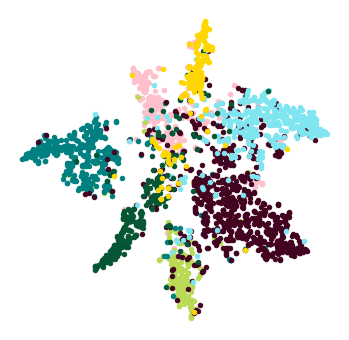

In [20]:
from bhtsne import tsne
import matplotlib.pyplot as plt
def plot_points(colors, embedding):
    z = tsne(embedding.astype('float64'))
    y = g.ndata['label'].numpy()

    plt.figure(figsize=(6, 6))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors, output.cpu().numpy())

不难看出，得到的节点嵌入的分离度非常高，大家可以将这幅图和第二次实践课上的deepwalk得到的图进行对比。

## 4. 利用GCN完成图分类任务

在这一节中，我们将使用GCN完成图分类任务。

### 4.1 图分类数据集介绍

图分类任务中，每张图都对应了一个标签，节点是不对应标签的。本小节我们以ENZYMES数据集为例来介绍图分类任务。

In [21]:
from dgl.data import TUDataset
dataset = TUDataset(name='ENZYMES', raw_dir='./data/ENZYMES')

In [22]:
print(dataset)
print(len(dataset))

600


我们可以看到ENZYMES数据集一共有600张图。下面让我们取出第一张图来看看：

In [23]:
g, label = dataset[0]
print(g)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float64), 'node_labels': Scheme(shape=(1,), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


这张图中共有168条边，37个节点，以及一个标签5。这个标签代表的是这个图的标签，因为该数据集属于图分类数据集。

### 4.2 图分类任务实践

In [30]:
from dgl.nn.pytorch.glob import AvgPooling 

class GCN(torch.nn.Module):
    """3层GCN+1层线性层"""

    def __init__(self, nfeat, nhid, nclass, dropout=0.2):
        super(GCN, self).__init__()
        
        self.gc1 = GraphConv(nfeat, nhid, activation=F.relu)
        self.gc2 = GraphConv(nhid, nhid, activation=F.relu)
        self.gc3 = GraphConv(nhid, nhid, activation=F.relu)
        self.lin = nn.Linear(nhid, nclass)
        self.avgpool = AvgPooling()
        self.dropout = dropout

    def forward(self, g, features):
        """模型前向传播"""
        h = self.gc1(g, features)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.gc2(g, h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        h = self.gc3(g, h)
        h = self.avgpool(g, h)
        h = self.lin(h)
        return F.log_softmax(h, dim=1)

In [31]:
from dgl.dataloading import GraphDataLoader
from dgl.data import TUDataset
from torch.utils.data import random_split

dataset = TUDataset(name='ENZYMES', raw_dir='./data/ENZYMES')

# 获取train和test的样本数量
train_num = int(0.8 * len(dataset))
test_num = int(0.2 * len(dataset))

# 使用Pytorch的random_split获取train和test的Dataset类
train_dataset, test_dataset = random_split(dataset, [train_num, test_num])

# 使用DGL的GraphDataLoader构建迷你批次数据
train_loader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=64)

In [32]:
# 从一个样本图里获取特征维度
g0, lable0 = dataset[0]
nfeat = g0.ndata['node_attr'].shape[1]
nclass = labels.max().numpy() + 1
nhid = 64
device = 'cpu'
# device = ‘cuda’ # 如果有CUDA的话

model = GCN(nfeat, nhid, nclass).to(device)

In [33]:
def train(model, lr=0.001, epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        loss_all = 0
        for batch_graphs, batch_labels in train_loader:
            # 每个批次里获取特征和处理标签
            batch_graphs = batch_graphs.to(device)
            features = batch_graphs.ndata['node_attr'].float()
            batch_labels = batch_labels.squeeze(dim=1)
            
            optimizer.zero_grad()
            # 前向传播
            preds = model(batch_graphs, features)
            # 计算损失
            loss = F.nll_loss(preds, batch_labels)
            loss.backward()
            loss_all += loss.item() * batch_labels.shape[0]
            # 反向传播
            optimizer.step()
            
        loss_train = loss_all / train_num 
        if epoch % 100 == 0:
            print('Epoch: {:03d}, Loss: {:.7f}'.format(epoch, loss_train))

def test(model, valid_loader):
    model.eval()
    correct = 0
    for batch_graphs, batch_labels in valid_loader:

        batch_graphs = batch_graphs.to(device)
        features = batch_graphs.ndata['node_attr'].float()
        batch_labels = batch_labels.squeeze(dim=1)

        pred = model(batch_graphs, features)
        correct += float(th.sum(th.argmax(pred,dim=1) == batch_labels).item())
    return correct / test_num

In [34]:
train(model, epochs=1000)

Epoch: 000, Loss: 2.0806363
Epoch: 100, Loss: 1.4864711
Epoch: 200, Loss: 1.1935936
Epoch: 300, Loss: 0.9288415
Epoch: 400, Loss: 0.7452060
Epoch: 500, Loss: 0.6061079
Epoch: 600, Loss: 0.4944332
Epoch: 700, Loss: 0.4028859
Epoch: 800, Loss: 0.3201658
Epoch: 900, Loss: 0.2730209


In [35]:
test(model, test_loader)

0.6416666666666667